# Project Title: Maternal Health Risk Prediction using GraphSAGE and Random Forest

**Description:** This project uses a GraphSAGE model to extract node embeddings from maternal health data and a Random Forest classifier to predict high-risk pregnancies.

**Date:** 25-08-2025

**Libraries:** PyTorch, NetworkX, Scikit-learn, SHAP, Matplotlib


# 1. Import Libraries

In this step, we import all required libraries. Libraries include data manipulation (pandas, numpy), visualization (matplotlib, seaborn), and machine learning tools (scikit-learn). Importing everything at the start ensures reproducibility and cleaner code.


In [1]:
# Data handling
import pandas as pd
import numpy as np

# Graph processing
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import euclidean_distances

# Model evaluation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier

# PyTorch for GraphSAGE
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

# Visualization
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import shap


# 2. Load Data

 We load the dataset from a CSV file into a pandas DataFrame. This step also includes previewing the first few rows to understand the structure of the data.


In [2]:
# Load CSV files
maternal = pd.read_csv('/content/maternal_health_risk.csv')
pree = pd.read_csv('/content/preeclampsia.csv')

# Add domain labels
maternal['domain'] = 0
pree['domain'] = 1

# Rename columns for consistency
maternal.rename(columns={'Age': 'age', 'SystolicBP': 'sysbp', 'DiastolicBP': 'diabp'}, inplace=True)

# Combine datasets
combined = pd.concat([maternal, pree], axis=0, ignore_index=True)

# Define target: 1 if high risk, 0 otherwise
combined['target'] = np.where(combined['RiskLevel'] == 'high risk', 1, 0)
combined['target'] = combined['target'].fillna(combined['htn'].fillna(0))


# 3. Preprocess Features

Preprocessing ensures data quality and readiness for modeling. This includes handling missing values, encoding categorical variables, normalizing or scaling features, and removing irrelevant columns.


In [3]:
features = ['age', 'sysbp', 'diabp', 'BS', 'BodyTemp', 'HeartRate', 'bmi', 'plgf:sflt', 'SEng']
X = combined[features].copy()

# Impute missing values
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=features)

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


# 4. Graph Construction

In [4]:
G = nx.Graph()

# Add nodes with features
for i in range(len(X_scaled)):
    G.add_node(i, features=X_scaled[i])

# Compute pairwise distances
dist_matrix = euclidean_distances(X_scaled)
threshold = 0.3

# Connect nodes within threshold distance
for i in range(len(X_scaled)):
    for j in range(i + 1, len(X_scaled)):
        if dist_matrix[i][j] < threshold:
            G.add_edge(i, j, weight=1 - dist_matrix[i][j])

# Convert graph to adjacency tensor
adj = nx.to_numpy_array(G)
adj_tensor = torch.tensor(adj, dtype=torch.float)
node_feats = torch.tensor(X_scaled, dtype=torch.float)
labels = torch.tensor(combined['target'].values, dtype=torch.float).unsqueeze(1)
domains = torch.tensor(combined['domain'].values, dtype=torch.float).unsqueeze(1)


# 5. Prepare Cross-Validation

In [5]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx_all, test_idx_all = next(cv.split(node_feats, labels.numpy()))


# 6. Define GraphSAGE Model

In [6]:
class GraphSAGE(nn.Module):
    def __init__(self, in_features, hidden=64, embed_size=32, dropout_rate=0.5):
        super().__init__()
        self.conv1 = nn.Linear(in_features * 2, hidden)
        self.conv2 = nn.Linear(hidden * 2, embed_size)
        self.recon_layer = nn.Linear(embed_size, in_features)
        self.domain_classifier = nn.Linear(embed_size, 1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, X, adj):
        neighbor_feats = adj @ X
        combined = torch.cat([X, neighbor_feats], dim=1)
        emb = F.relu(self.conv1(combined))
        emb = self.dropout(emb)
        neighbor_feats2 = adj @ emb
        combined2 = torch.cat([emb, neighbor_feats2], dim=1)
        emb = F.relu(self.conv2(combined2))
        recon = self.recon_layer(emb)
        return emb, recon

    def domain_forward(self, emb):
        return torch.sigmoid(self.domain_classifier(emb))


# 7. Federated GraphSAGE Training

In [7]:
graphsage_model = GraphSAGE(in_features=node_feats.shape[1])
optimizer = Adam(graphsage_model.parameters(), lr=0.01)
recon_criterion = nn.MSELoss()
domain_criterion = nn.BCELoss()
best_loss = float('inf')
patience = 10
counter = 0

# Client indices
maternal_idx = combined[combined['domain'] == 0].index
pree_idx = combined[combined['domain'] == 1].index
clients = [maternal_idx, pree_idx]
local_models = [GraphSAGE(in_features=node_feats.shape[1]) for _ in clients]

for epoch in range(100):
    total_loss = 0
    for i, client_idx in enumerate(clients):
        local_model = local_models[i]
        local_model.train()
        optimizer.zero_grad()
        emb, recon = local_model(node_feats[client_idx], adj_tensor[client_idx][:, client_idx])
        recon_loss = recon_criterion(recon, node_feats[client_idx])
        domain_pred = local_model.domain_forward(emb)
        domain_loss = domain_criterion(domain_pred, domains[client_idx])
        loss = recon_loss + 0.5 * domain_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Federated averaging
    with torch.no_grad():
        for param, *local_params in zip(graphsage_model.parameters(), *[m.parameters() for m in local_models]):
            param.data = sum(p.data for p in local_params) / len(local_models)

    # Early stopping
    graphsage_model.eval()
    with torch.no_grad():
        val_emb, val_recon = graphsage_model(node_feats[test_idx_all], adj_tensor[test_idx_all][:, test_idx_all])
        val_loss = recon_criterion(val_recon, node_feats[test_idx_all])
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            break
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Val Loss {val_loss:.4f}")


Epoch 0: Val Loss 23.1597


# 8. Extract GraphSAGE Embeddings

In [8]:
graphsage_model.eval()
with torch.no_grad():
    embeddings, _ = graphsage_model(node_feats, adj_tensor)
    embeddings = embeddings.numpy()


# 9. Random Forest Classifier

Random Forest is an ensemble learning method that combines multiple decision trees to improve prediction accuracy and reduce overfitting.  
- **Training:** The model builds multiple decision trees on random subsets of features and data.  
- **Prediction:** Each tree predicts the class, and the majority vote determines the final output.  
- **Evaluation:** Accuracy, confusion matrix, and classification report are used to assess performance, enabling comparison with Logistic Regression.


In [9]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(embeddings[train_idx_all], labels[train_idx_all].numpy().ravel())


RandomForestClassifier(class_weight='balanced', random_state=42)

# 10. Evaluation

This section summarizes key findings, including which model performs better and the implications for maternal health risk prediction. It also mentions limitations and potential future improvements.


In [10]:
test_preds = rf_model.predict(embeddings[test_idx_all])
acc = accuracy_score(labels[test_idx_all].numpy(), test_preds)
auc = roc_auc_score(labels[test_idx_all].numpy(), rf_model.predict_proba(embeddings[test_idx_all])[:, 1])
print(f"GraphSAGE + Random Forest Accuracy: {acc:.4f}, AUC: {auc:.4f}")
print(classification_report(labels[test_idx_all].numpy(), test_preds))


GraphSAGE + Random Forest Accuracy: 0.9293, AUC: 0.9780
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.96       228
         1.0       0.79      0.87      0.83        55

    accuracy                           0.93       283
   macro avg       0.88      0.91      0.89       283
weighted avg       0.93      0.93      0.93       283



# 11. Visualizations

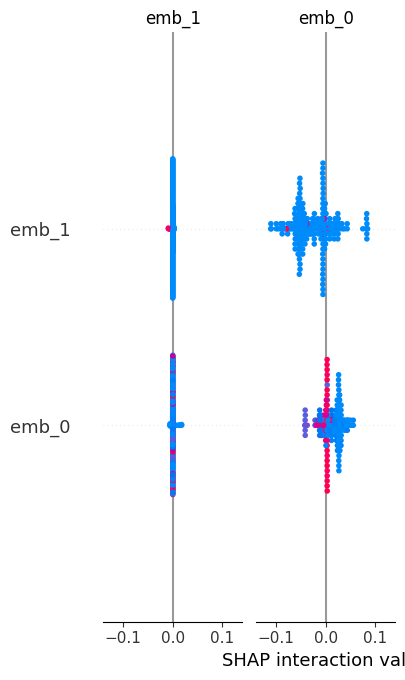

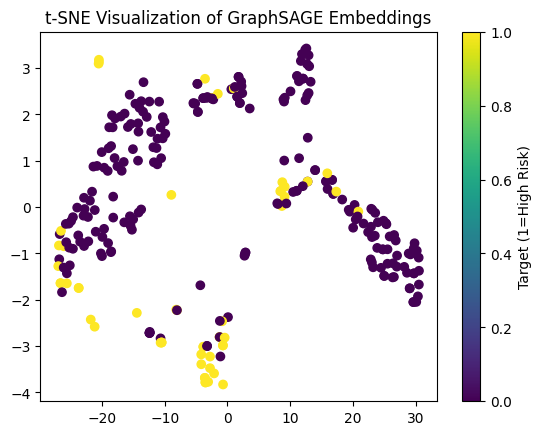

In [11]:
# SHAP explanations
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(embeddings[test_idx_all])
shap.summary_plot(shap_values, embeddings[test_idx_all], feature_names=[f'emb_{i}' for i in range(embeddings.shape[1])])

# t-SNE visualization
tsne = TSNE(n_components=2, random_state=42)
embed_2d = tsne.fit_transform(embeddings[test_idx_all])
plt.scatter(embed_2d[:, 0], embed_2d[:, 1], c=labels[test_idx_all].numpy(), cmap='viridis')
plt.colorbar(label='Target (1=High Risk)')
plt.title('t-SNE Visualization of GraphSAGE Embeddings')
plt.show()
